# 1.Find a data
* 해결하고 싶은 문제가 무엇인지 확인하고 그에 맞는 dataset을 찾는다.

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [ ]:
# bing API 를 이용해서 이미지 검색 (or ddg)
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [ ]:
# grizzly bear에 대한 이미지 검색을 수행
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [ ]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

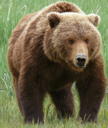

In [ ]:
# dest path에 있는 이미지를 열어서 확인
im = Image.open(dest)
im.to_thumb(128,128)

# 2. Classification 


In [ ]:
# 분류할 곰의 종류 나누기 
bear_types = 'grizzly','black','teddy'  # 여기서는 세가지 종류로 나눔
path = Path('bears')  #경로 설정

In [ ]:
if not path.exists():
    path.mkdir()
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls=results)

In [ ]:
fns = get_image_files(path)
fns

(#571) [Path('bears/teddy/7b836de3-e805-4683-bb96-21c0dae965a1.jpg'),Path('bears/teddy/0ad02997-1657-48ed-acff-624db093b820.jpg'),Path('bears/teddy/6bde0404-80a0-4c53-a7d2-f86462266313.jpg'),Path('bears/teddy/8f519e32-32e9-4239-a7b9-f07bd4cd705c.jpg'),Path('bears/teddy/659f16d0-8627-41a2-8677-7b5122f07966.jpeg'),Path('bears/teddy/a205aac6-b202-4603-8434-491189822475.jpg'),Path('bears/teddy/82679d02-990a-4832-8e16-a14a48d4e10a.jpg'),Path('bears/teddy/49e33474-3986-4931-af1c-2bfcbab9cd8f.jpg'),Path('bears/teddy/62dde711-f071-40e4-8a55-257172b66bbb.jpg'),Path('bears/teddy/02a65d40-b009-40e8-9165-7f241684aae1.jpg')...]

In [ ]:
# Check if download has failed
failed = verify_images(fns)
failed

(#16) [Path('bears/teddy/7768e8ec-f627-4078-be39-64c8a7c98c26.jpg'),Path('bears/teddy/89e575fb-4e9e-42a8-8f4e-a3ebfbb73ffe.jpg'),Path('bears/teddy/71cecb88-96ed-4608-9bf0-14d234d717e3.jpg'),Path('bears/teddy/e94efa5b-cf06-47cf-baf3-c9d1e09fc0e1.jpg'),Path('bears/teddy/a2a2b93e-f389-4ca5-9acb-dec4c0382699.jpg'),Path('bears/teddy/41166fd8-96df-4ef2-98c8-3a44ab585ddf.JPG'),Path('bears/teddy/68d80b02-460d-410e-9f25-6ef87a4e140b.JPG'),Path('bears/teddy/42dfac45-27ff-480f-9bcd-f057c3106e2c.JPG'),Path('bears/teddy/096d0d44-fd70-444f-9131-ecf1f9ad4b84.JPG'),Path('bears/black/cde9ae0b-bbbe-4e6d-a3a9-03fff394a0c7.jpg')...]

In [ ]:
failed.map(Path.unlink);

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path) # the path where the images can be found

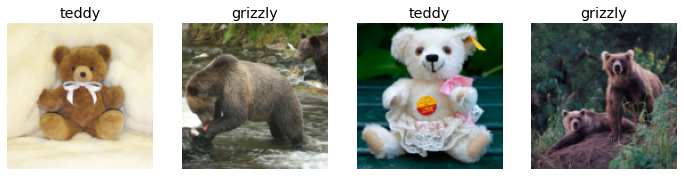

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

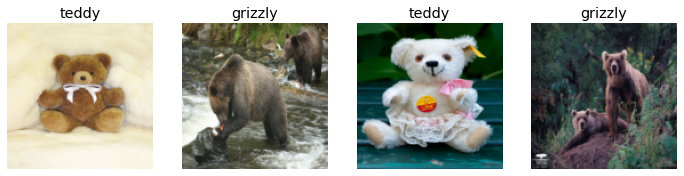

In [ ]:
# Squish 를 사용하면 얇아진다. -> 2,4번째 사진 보면 명확
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

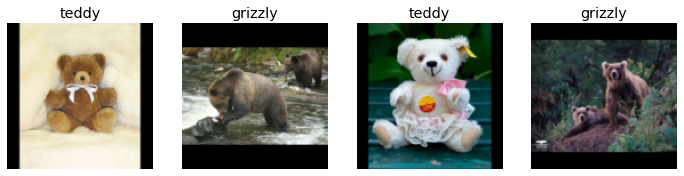

In [ ]:
# Pad mode중 zero를 사용하면 위아래로 Black 공간이 생기게 된다. 
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Resize : 위에서 여러 methods를 사용한 것 처럼 필요에 따라서 다양한 방식으로 사진에 통일성을 부여할 수 있다. 

## Data Augmentaion 
아래와 같은 방식으로 RandomResizeCrop 을 사용하면 같은 사진이어도 여러 종류의 사진을 생성해낼 수 있기 때문에 data augmentation이라고 할 수 있다. 

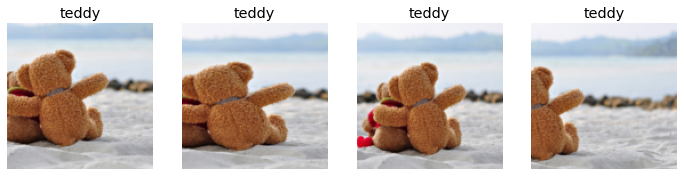

In [ ]:
# RandomResizedCrop (num, num) -> 출력할 Size를 조정해줄 수 있다. 
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

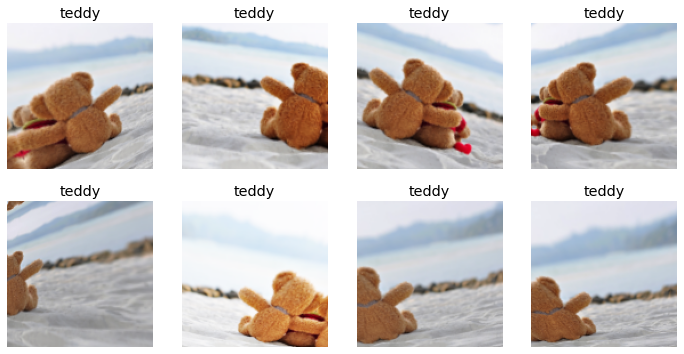

In [ ]:
# aug_transforms = 
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.214039,0.152275,0.054054,01:44


epoch,train_loss,valid_loss,error_rate,time
0,0.238245,0.204322,0.054054,02:22
1,0.178745,0.200826,0.063063,02:32
2,0.169638,0.179658,0.081081,02:21
3,0.145824,0.159313,0.063063,02:18


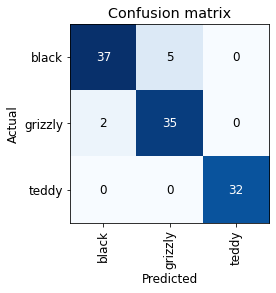

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

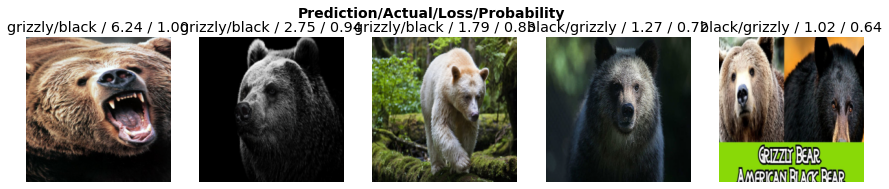

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.dls.vocab

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])